In [1]:
%load_ext autoreload
%autoreload 2
from importlib import reload

from collections import defaultdict

import numpy

import random
from matplotlib import pyplot as plt
from random import shuffle, choice, randint

import math
import keras
import tensorflow

from NN_utils import BigTable, WeightClip

import pickle
import zlib

def logistic(x, b,off):
    z = b*(x-off)
    return numpy.exp(z)/(1+numpy.exp(z))

def pr_to_spread(p, comps=1, as_A_and_D=True):
    per_comp_p = p**(1/(comps))
#     print("p         ", p)
#     print("per comp p", per_comp_p)
#     spread = -numpy.log((1.0/per_comp_p)-1.0)
    inv_sigmoid = lambda pr : ( -numpy.log((1/pr) -1) )
    spread = inv_sigmoid(per_comp_p)
#     print("spread    ", spread)
    if as_A_and_D:
        a = spread/2.0
        d = -spread/2.0
        return a,d
    else:
        return spread

print("started")


from sklearn.svm import SVR

Using TensorFlow backend.


started


In [2]:
from numpy.random import uniform, random_integers
from scipy.stats import truncnorm

def gen_bayes_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits):
    students = numpy.zeros((n_students, n_factors))
    for six in range(n_students):
#         true_comps = numpy.random.normal(a0, a1, size=n_factors)#+0.2#+2#+1.2
#         true_comps = numpy.random.normal(0, 5/3, size=n_factors)#+0.2#+2#+1.2
        true_comps = numpy.random.uniform(0,1, size=n_factors)#+0.2#+2#+1.2
        for cix,c in zip(range(n_factors), true_comps):
            students[six,cix] = c

    questions = numpy.zeros((n_questions, n_factors))
    for qix in range(n_questions):
#         n_comps = randint(min_active_traits, max_active_traits)
        n_comps = n_factors
        comp_ixs = numpy.random.choice(range(n_factors), size=n_comps, replace=False)
        true_comps = numpy.random.uniform(a0[0],a0[1], size=n_comps)

        for cix,c in zip(comp_ixs,true_comps):
            questions[qix,cix] = c#+boost
    
    print("genqs",students.shape, questions.shape)
    return students, questions

def gen_bayes_run(n_traits, a0, a1, min_active_traits, max_active_traits, test_w=None, n_students=8, n_questions=8):
    students, questions = gen_bayes_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits)
    print(students.shape, questions.shape)
    obs = numpy.zeros((len(students), len(questions)))
    probs = numpy.zeros((len(students), len(questions)))
    vz = []
    mz = []
    scz =[]
    for vi in range(len(students)):
        for mi in range(len(questions)):
            prs = (1-questions[mi]) + (questions[mi]*students[vi])
            pr = numpy.prod(prs)
            obs[vi,mi] = (random.random() < pr)
            probs[vi,mi] = pr
    return obs, probs, students, questions

# n_students, n_questions, n_factors, min_active, max_active = 100,100,10,10,10

In [3]:
from numpy.random import uniform, random_integers
from scipy.stats import truncnorm

def gen_rasch_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits, test_w):
    students = numpy.zeros((n_students, n_factors))
#     for six in range(n_students):
#         true_comps = numpy.random.normal(0, a1, size=n_factors)#+0.2#+2#+1.2
# #         true_comps = numpy.random.normal(0, 5/3, size=n_factors)#+0.2#+2#+1.2
# #         true_comps = numpy.random.uniform(0,1, size=n_factors)#+0.2#+2#+1.2
#         for cix,c in zip(range(n_factors), true_comps):
#             students[six,cix] = c

    students = numpy.random.normal(0, a1, size=(n_students,n_factors))
            
    av_c = (min_active_traits + max_active_traits)/2
    d50 = pr_to_spread(.5, av_c, as_A_and_D=False)
    
    questions = numpy.zeros((n_questions, n_factors)) - 10
    
    minb=-(test_w/2) -a0 - d50
    maxb=(test_w/2) -a0 - d50
    questions = questions
    minb, maxb = sorted([minb, maxb])
    minb = float(minb)
    maxb = float(maxb)
    
    for qix in range(n_questions):
        n_comps = randint(min_active_traits, max_active_traits)
#         print("n_comps", n_comps)
        comp_ixs = numpy.random.choice(range(n_factors), size=n_comps, replace=False)  
#         print("range=", minb,maxb)
        true_comps = numpy.random.uniform(minb, maxb, size=n_comps)
        for cix,c in zip(comp_ixs,true_comps):
            questions[qix,cix] = c
            
    return students, questions


def calc_probs_from_embs(students,questions):
    students2 = numpy.repeat(students, len(questions), axis=0)
    questions2 = numpy.tile(questions, (len(students),1))
    zmask = numpy.isclose(questions2,-10).astype(int)
    diffs = students2-questions2
    prs = 1.0/(1.0+ numpy.exp(-diffs))
    prs = numpy.maximum(zmask,prs)
    probs2 = numpy.prod(prs, axis=1).reshape(len(students), len(questions))
    return probs2

def gen_rasch_run(n_factors, a0, a1, min_active_traits, max_active_traits, test_w=None, n_students=8, n_questions=8):
    students, questions = gen_rasch_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits, test_w=test_w)
    obs = numpy.zeros((len(students), len(questions)))
    vz = []
    mz = []
    scz =[]
    
#     students2 = numpy.repeat(students, n_questions, axis=0)
#     questions2 = numpy.tile(questions, (n_students,1))
    
# #     print("st and qn shapes:")
# #     print(students.shape)
# #     print(questions.shape)
    
#     zmask = numpy.isclose(questions2,-10).astype(int)
# #     print("zmask shape:", zmask.shape)
#     diffs = students2-questions2
# #     print("diffs shape:", diffs.shape)
#     prs = 1.0/(1.0+ numpy.exp(-diffs))
#     prs = numpy.maximum(zmask,prs)
#     probs2 = numpy.prod(prs, axis=1).reshape(n_students, n_questions)
        
    probs2 = calc_probs_from_embs(students, questions)
#     for vi in range(len(students)):
#         for mi in range(len(questions)):
#             zmask = numpy.isclose(questions[mi],-10).astype(int)
#             diffs = students[vi]-questions[mi]
#             prs = logistic(diffs,1,0)
#             prs = numpy.maximum(zmask,prs)

#             pr = numpy.prod(prs)
#             obs[vi,mi] = (random.random() < pr)
#             probs[vi,mi] = pr
            
    return obs, probs2, students, questions



In [4]:
# from scipy.stats import beta
# # n_questions = 100
# # n_students = 100
# # n_factors = 2

# def gen_run(n_movies, n_viewers, n_factors, min_active, max_active):
#     from numpy.random import randint, uniform

#     mina,maxa =(0,1)
#     minb,maxb =(0,1)
#     movies = randint(minb, maxb+1, size=(n_movies, n_factors))
#     viewers = randint(mina, maxa+1, size=(n_viewers, n_factors))
# #     movies =  beta.rvs(2, 2, size=(n_movies, n_factors))
# #     viewers = beta.rvs(2, 2, size=(n_movies, n_factors))

#     plt.hist(movies.flatten(), alpha=0.5)
#     plt.hist(viewers.flatten(), alpha=0.5)
#     plt.show()
    
#     print(movies)
#     print(viewers)

#     sig = lambda z : 1/(1+numpy.exp(-z))

#     obs = numpy.zeros((len(viewers), len(movies)))
#     #obs = numpy.matmul(viewers, movies.T)/n_factors
#     vz = []
#     mz = []
#     scz =[]
#     for vi in range(len(viewers)):
#         for mi in range(len(movies)):
# #             obs[vi,mi] = numpy.prod(sig(viewers[vi] - movies[mi]))
#             obs[vi,mi] = numpy.dot(viewers[vi], movies[mi])
# #             prxd = numpy.multiply(viewers[vi], movies[mi])
# #             obs[vi,mi] = numpy.sum(prxd)
# #             obs[vi,mi] = numpy.random.randint(0,2)
#             print(viewers[vi], movies[mi],"=",obs[vi,mi])
#     plt.hist(obs.flatten())
#     plt.show()
    
#     return obs, None, viewers, movies

In [5]:
# n_students, n_questions, n_factors, min_active, max_active = 100,150,100,1,5

# numpy.set_printoptions(precision=3)
# test_w = 5
# #rasch a0 = 3
# # a0 = 0.26 #bayes10
# a0 = (0.2,1)
# a1 = None
# # obs, probs, students, questions  = gen_bayes_run(n_factors, a0, a1, min_active, max_active, test_w=test_w, n_students=n_students, n_questions=n_questions)
# obs, probs, students, questions  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w=test_w, n_students=n_students, n_questions=n_questions)

# plt.hist(students.flatten(), alpha=0.5)
# plt.hist(questions.flatten(), alpha=0.5)
# plt.show()

# plt.hist(probs.flatten())
# plt.show()

# plt.hist(obs.flatten())
# plt.show()

In [81]:
from keras.regularizers import l1
from keras.layers import Dropout, multiply, subtract, GaussianNoise, GaussianDropout, Input, Lambda, Embedding, Flatten, concatenate
from keras import backend as K, Model
def generate_qs_model(qn_table, psi_table, optimiser, _mode="MXFN", loss="MSE"):
    
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")

#     psi_row = Flatten(Embedding(psi_n, 100, input_length=1)(psi_sel))
#     qn_row = Flatten(Embedding(qn_n, 100, input_length=1)(qn_sel))
    
#     print(qn_table, psi_table, psi_sel, qn_sel)
#     print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
    
    qn_row = qn_table(qn_sel)
    psi_row = psi_table(psi_sel)

    print("Mode is", _mode)
    if _mode=="DEEP":
#         difs = concatenate([psi_row, qn_row])
        difs = subtract([psi_row, qn_row])
#         h = Dense(128, activation="relu")(difs)
        h = Dense(64, activation="relu")(difs)
#         h = Dense(32, activation="relu")(h)
#         h = Dense(16, activation="relu")(h)
#         h = Dense(8, activation="relu")(h)
        score = Dense(1, activation="sigmoid")(h)        
    elif _mode=="COND":
        Prs = Lambda(lambda qs: (1 - qs[0])+(qs[0]*qs[1]), name="Prs")([qn_row, psi_row])
        score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="score")(Prs)
#     elif _mode=="BINQ":
#         Prs = Lambda(lambda qs: (1 - qs[0])+(qs[0]*qs[1]), name="Prs")([qn_row, psi_row])
#         score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="score")(Prs)
    elif _mode=="MLTM":
        klip = Lambda(lambda qk: K.clip(qk,-10, -9)+10)
        q_masque = klip(qn_row)
        difs = subtract([psi_row, qn_row])
        Prs = Lambda(lambda z: (1.0 / (1.0 + K.exp(-z))), name="Pr_sigmoid1")(difs)
        Prs = Lambda(lambda ps_q:  ps_q[0]*ps_q[1] + (1-ps_q[1]) ) ([Prs, q_masque])
        score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="score")(Prs)
    else:
        if _mode!="MXFN":
            print("Invalid mode:", _mode, "- valid modes are COND, MLTM, MXFN (using default: MXFN)")
        _mode=="MXFN"
        scores = Lambda(lambda qp: qp[0] * qp[1])([qn_row, psi_row])
        score = Lambda(lambda s: K.sum(s, keepdims=True, axis=1), name="sum")(scores)
#         score = Lambda(lambda qp: K.batch_dot(qp[0], qp[1], axes=1), name="dot_prod")([qn_row, psi_row])
    #     score = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)))(score)
    
    model = Model(inputs=[qn_sel, psi_sel], outputs=score)

#     if _mode=="BINQ":
#         from_half = Lambda(lambda x: 1+K.sum((0.25-(x-0.5)**2)) )
#         s_loss = from_half(psi_table.kernel)
#         q_loss = from_half(qn_table.kernel)
#         def custom_loss(s_loss,q_loss):
#             def orig_loss(yt,yh):
#                 return K.binary_crossentropy(yt,yh) * s_loss * q_loss
# #             return K.mean(K.square(yt-yh)) + 5000*aux_av + 1000*aux_std + aux_loss/10000
#             return orig_loss
#         model.compile(optimizer=optimiser, loss=custom_loss(s_loss, q_loss), metrics=["accuracy"])
#         return model
    
    print("loss mode is", loss)
    if loss=="MSE":
        model.compile(optimizer=optimiser, loss="mse", metrics=["accuracy"])
    else:
        if loss!="XENT":
            print("loss mode must be MSE or XENT, not", loss," - setting to XENT.")
            loss="XENT"            
        model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])     
    print(model.summary())

    return model

In [7]:
from keras.regularizers import l1
from keras.layers import Dropout, multiply, subtract, GaussianNoise, GaussianDropout, Input, Lambda, Dense
from keras import backend as K, Model
from keras.optimizers import Adam
def generate_offset_generator(w=5,d=4):
    #width, dispersal, target_EV
    h=None
    inp = Input(shape=(3,))
    for _ in range(d):
        if h==None:
            h = Dense(w, activation="relu")(inp)
        else:
            h = Dense(w, activation="relu")(h)
    last_layer=inp if (h is None) else h
    offset = Dense(1, activation="linear")(last_layer)
    model = Model(inputs=[inp], outputs=[offset])
    model.compile(optimizer=Adam(), loss="mse")
    print(model.summary())
    return model

In [8]:
# a1 = 5/3
# a0 = 1.75
# tw = 3.5
from sklearn.metrics import mean_squared_error

from keras.callbacks import EarlyStopping
def create_offset_generator(n_factors, min_active, max_active, sampsize=14, n_iter=20000, rasch=True):
    n_questions = int(sampsize / 0.9)
    n_students = int(sampsize / 0.9)
    inps = []
    outs = []

    i=0
#     for a in range(n_iter):
    print("generating generator training mini-datasets...")
    n_dropped = 0
    while i < n_iter:

#         tw = random.uniform(0, 5)
#         a0 = random.uniform(-4, 5)
#         a1 = random.uniform(.5, 4)

        tw = random.uniform(0, 5)
        a0 = random.uniform(-5, 5)
        a1 = random.uniform(0, 4)

#         tw = random.uniform(0, 10)
#         a0 = random.uniform(-10, 10)
#         a1 = random.uniform(0, 10)


#         print(tw,a1,"...",a0)
        
        if rasch:
            _, probs, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=n_questions)
        else:
            _, _, students_temp, qz_temp  = gen_bayes_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=n_questions)

        students2 = students_temp
        questions = qz_temp


        obs = (random.random() < probs).astype(int)
        exp_ob = numpy.mean(probs.flatten())
        if exp_ob <= 0.1 or exp_ob >= 0.9:
            n_dropped +=1
            continue
        i+=1
            
#         hard =numpy.round(probs)
#         plt.hist(hard.flatten())
#         plt.show()

#         agt = 0 #numpy.zeros_like(probs)
#         n_agt_runs = 20
#         for _ in range(n_agt_runs):
#             this_obs  = (numpy.random.random(probs.shape) < probs).astype(int)
# #             plt.hist(this_obs.flatten())
# #             plt.show()
#             this_agt = numpy.mean(((hard==this_obs).astype(float)).flatten())
# #             this_agt= numpy.std(probs.flatten() -0.5 )
# #             print("Agt:", this_agt)
#             agt += this_agt 
#         agt /= n_agt_runs
        
#         plt.hist(probs.flatten())
#         plt.show()
#         print("tw, a1, a0", tw, a1, a0)
#         print("Mean agt:", agt)
#         print("Exp pr:", exp_ob)
        
        
        print(i, exp_ob)
        inps.append([tw,a1, exp_ob])
        outs.append(a0)
#         for p in probs.flatten():
#             inps.append([tw,a1, p])
#             outs.append(a0)
        
    print("done!")

    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    
    split = len(inps)//10
    vinps = numpy.array(inps[split:])
    vouts = numpy.array(outs[split:])
    inps = numpy.array(inps[:split])
    outs = numpy.array(outs[:split])
    print(inps.shape, outs.shape)

    best_mse = math.inf
    best = None
    best_dims = None
#     seen = set()
                        
    for nnw in [16]: # [2,4,8,16,32]:
        for nnd in [2]: #[0,1,2,3,5]:
#             if (nnw,nnd) in seen:
#                 continue
#             seen.add((nnw,nnd))
            gen_m = generate_offset_generator(nnw, nnd)
            h = gen_m.fit(inps,outs, epochs=10000, shuffle=True, batch_size=len(inps), callbacks=[es], validation_split=0.1, verbose=1)
            
#             gen_m = SVR()
#             gen_m.fit(inps, outs)
            
            mse = mean_squared_error(vouts,gen_m.predict(vinps))
            if mse < best_mse:
                print("new best:",nnw,nnd,":",mse)
                best_mse = mse
                best_dims = (nnw,nnd)
                best = gen_m
    
    predz = best.predict(inps)
#     for i,p,o in zip(inps,predz, outs):
#         print(i, p, o)
    print("Best generator for", (n_factors, min_active, max_active), "is", best_dims)
    print("avg", numpy.mean(outs), "vs", numpy.mean(predz))
    print("number of extreme cases = ", n_dropped, "as prop of ",n_iter," iters", n_dropped/n_iter)
    print(mean_squared_error(vouts, best.predict(vinps)))
    
    h=None
    return best, h, best_dims, best_mse

In [9]:
def calc_arr_arr_err(split, real_wgts, pred_wgts, max_iter=10):
    from scipy.spatial.distance import cosine
# pred_wgts = numpy.round(pred_wgts,1)

    print(split, real_wgts.shape, pred_wgts.shape, max_iter)

    out_cols = [None] * len(real_wgts.T)
    curr_sel = None
    curr_ix = None
    n_iters = 10
    chosen = None
    curr_real_ix = None
    
    indices = range(len(real_wgts.T))

    min_total_err = math.inf
    best_dis = math.inf
    for i in range(max_iter): #len(indices)**2):
        real_used = set()
        pred_used = set()
        while len(pred_used) < len(indices):
            curr_err = math.inf
            curr_cos = math.inf
            for rix in numpy.random.permutation(indices):
                if rix in real_used:
                    continue
                real_col = real_wgts.T[rix]
                for cix in numpy.random.permutation(indices):
                    if cix in pred_used:
                        continue
                    pred_col = pred_wgts.T[cix]
                    pred_col = pred_col #* pred_q_col
                    err = numpy.mean(numpy.abs( pred_col - real_col))
                    
                    if err < curr_err:
                        curr_sel = pred_col
                        curr_err = err
                        curr_cos = 0#cosine(pred_col, real_col)
                        curr_ix = cix
                        curr_real_ix = rix
            real_used.add(curr_real_ix)
            pred_used.add(curr_ix)
            out_cols[curr_real_ix] = curr_sel
        out_col_arr = numpy.array(out_cols).T
        total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
        
        dis = 0
        mean_ll = numpy.mean( out_col_arr - real_wgts )
        if total_err < min_total_err:
            min_total_err = total_err
            total_q_err = numpy.mean(numpy.abs( out_col_arr[0:split] - real_wgts[0:split] ))
            total_s_err = numpy.mean(numpy.abs( out_col_arr[split:] - real_wgts[split:] ))
            best_ll = mean_ll
            chosen = out_col_arr
            best_dis = dis
    return chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_dis


In [10]:
import copy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
def plot_items(pred_list, real_items, s_offset):
    if real_items.shape[1]<2:
        print("real_items is only 1 component wide .. needs to be >1 to plot on a PCA graph")
        return None
    elif real_items.shape[1]==2:
        print("2 comps, so no dim reduc")
        tx=None
    else:
        tx = PCA(n_components=2)
#         tx = TSNE(n_components=2)
    fyrst = True
    Cs = []
    C_labs = []
    pred_list = numpy.array(pred_list)
    print("pred list shape", pred_list.shape)
    print("real items shape", real_items.shape)


    fitted_pred_list = []
#     offset = numpy.median(pred_list[(pred_list>0.1)], axis=0) - numpy.median(real_items[(real_items>0.1)], axis=0)
#     real_mean = numpy.min(real_items[real_items > 0.1])
#     offset = numpy.min(pred_list[pred_list > 0.1]) - real_mean
#     print("real mean", real_mean)
#     print("offset", offset)
    
    m = len(real_items)
    cols = list(range(m))
    shuffle(cols)
    
    xmeans = numpy.zeros(m)
    ymeans = numpy.zeros(m)
    pairs = defaultdict(list)
    iter = 0
    
    cp_real = copy.copy(real_items)
    cp_real[cp_real < 1] = numpy.nan
    r_offset=numpy.nanmedian(cp_real, axis=0)
    
    itemz_2 = real_items
    n = len(real_items)
    
    for opreds in pred_list:
        preds = copy.copy(opreds) #- s_offset[iter] + r_offset
        split = 0
        
        items_chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, real_items, preds, max_iter=10)

        itemz_pred = items_chosen
        print(itemz_pred)
#         itemz_pred = numpy.maximum(itemz_pred,0)
        fitted_pred_list.append(itemz_pred)
        
#         itemz = real_items #- offset
#         print(numpy.min(itemz), numpy.mean(itemz), numpy.max(itemz))
#         itemz = numpy.maximum(itemz,0)
#         print(numpy.min(itemz), numpy.mean(itemz), numpy.max(itemz))
#         if itemz_2 is None:
#             itemz_2 = numpy.concatenate([real_itemz, itemz_pred], axis=0)
#         else:
        itemz_2 = numpy.concatenate([itemz_2, itemz_pred], axis=0)

    if tx:
        itemz_2 = tx.fit_transform(itemz_2)
#         itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
#         if fyrst:
#         itemz_2 = tx.fit_transform(itemz_2)
#             fyrst = False
#         else:
#             itemz_2 = tx.transform(itemz_2)

    from sklearn.cluster import KMeans
    iter=0
    fig = plt.gcf()
    fig.set_size_inches(10, 10)
    
    for opreds, itemz_pred in zip(pred_list, fitted_pred_list):
        n = len(itemz_pred)
        km = KMeans()
        km.fit(itemz_pred)
        cluster_labels = km.predict(itemz_pred)
        print(cluster_labels)
        
        C = []
        for l in set(cluster_labels):
            cluster = list(numpy.where(cluster_labels==l)[0])
            print("X", cluster)
            C.append(cluster)
        Cs.append(C)
        C_labs.append(cluster_labels)
                
#         NUM_COLORS = 100
#         cm = plt.get_cmap('gist_rainbow')
#         fig.gca().set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
        print(type(itemz_2))
        minix=n*(iter+1)
        maxix=n*(iter+1)+n
        
        #i=0 -> 100,199
        #i=2 -> 200,299
        
        print("no pts=",n," indices=", minix, maxix)
        print("shape of itemz_2", itemz_2.shape)
        fig.gca().scatter(itemz_2[minix:maxix,0], itemz_2[minix:maxix,1], alpha=0.7, c=numpy.array(cols), cmap=plt.get_cmap('nipy_spectral'))
        j=0
        for j in range(n):
            x,xh,y,yh = itemz_2[j+(n*iter),0], itemz_2[j+(n*iter+n) ,0], itemz_2[j+(n*iter),1], itemz_2[j+(n*iter+n),1]
#             fig.gca().plot([x,xh],[y,yh],  color="#aaaaaa80")
            xmeans[j] += xh
            ymeans[j] += yh
            pairs[iter].append((xh, yh))
        iter+=1
        
    for j in range(n):
        fig.gca().annotate(j, (itemz_2[j,0], itemz_2[j,1]))
        
    fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], c="b", zorder=10, alpha=0.5)
#     fig.gca().axhline(y=1e-6, linestyle="--")
#     fig.gca().axvline(x=1e-6, linestyle="--")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    
    xmeans = xmeans / len(pred_list)
    ymeans = ymeans / len(pred_list)
    

    if len(pred_list)>=1:
        for it in range(len(pred_list)):
            xhyh_pairs = pairs[it]
            for j,hat_pair in enumerate(xhyh_pairs):
                xh,yh = hat_pair
                x,y = itemz_2[j,0], itemz_2[j,1]
                mux = xmeans[j]
                muy = ymeans[j]
#                 fig.gca().scatter(xh, yh, alpha=0.7, c=plt.get_cmap('nipy_spectral')(cols[j]))
#                 fig.gca().scatter(mux,muy, c="#888888ff", marker="*", zorder=10)
#                 fig.gca().plot([mux,xh],[muy,yh],color="#aaaaaa80", linestyle="--")
#                 fig.gca().plot([mux,x],[muy,y],color="#888888dd", linestyle="-")
                fig.gca().plot([x,xh],[y,yh],color="#aaaaaa80", linestyle="--")
        
    plt.show()
    print("len Cs", len(Cs))
    from sklearn.metrics.cluster import adjusted_rand_score
    rands = []
    for ix in range(len(Cs)):
#         print(ix)
        for jx in range(len(Cs)):
#             print(jx)
            if ix!=jx:
#             print(Cs[ix], Cs[jx])
#                 print("VI:", ix,jx, varinfo(Cs[ix],Cs[jx]))
                a_rand = adjusted_rand_score(C_labs[ix], C_labs[jx])
                print("Rand:", a_rand)
                rands.append(a_rand)
    print("Mean rand score =", numpy.mean(rands), numpy.std(rands))

# qws = qn_table.get_weights()[0]
# qws2 = qn_table2.get_weights()[0]

In [11]:
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score
def generate_and_train(n_students, n_questions, qz,sz,pfz, vqz,vsz,vpfz, w, n_factors, min_active, max_active, nn_mode=None, loss_mode=None):
    btm = 0
    top = math.sqrt(.1/w)
#     init= (btm,top)
#     init = math.sqrt(.5/w)
    init_s = (0,1)
    init_q = (0,1)
    
#     1-p + pq = s
#     q=0.3 : 1-p + p/3 = s
#           : 3-3p + p = s
#           : p = (3-s)/2
        
    if nn_mode=="COND":
        percompp = .5**(1/w)
        print("percompp", percompp)

        s_table =  BigTable((n_students, w), 0,1, init_hilo= percompp )#, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), 0,1, init_hilo= percompp )#, regulariser=regularizers.l1(10e-6))
    elif nn_mode=="MXFN":
        init = math.sqrt(.5/w)
        print("MXFN init'n")
        print(init)
        print(init*init*w)
        s_table =  BigTable((n_students, w), -math.inf, math.inf, init_hilo= init) #, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), -math.inf, math.inf, init_hilo= init) #, regulariser=regularizers.l1(10e-6))
    elif nn_mode=="MLTM":
        sp = pr_to_spread(.5, w, as_A_and_D=False)
        print("sp is ",sp)
        s_table =  BigTable((n_students, w), -math.inf, math.inf, init_hilo= 0) #, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), -math.inf, math.inf, init_hilo= -sp) #, regulariser=regularizers.l1(10e-6))        
    else:
        s_table =  BigTable((n_students, w), -math.inf, math.inf, init_hilo= 0) #, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), -math.inf, math.inf, init_hilo= 0) #, regulariser=regularizers.l1(10e-6))        
                
    from keras.layers import Embedding
    from keras.constraints import NonNeg, MinMaxNorm
    from keras.initializers import RandomNormal, RandomUniform
    
#     wc=WeightClip(0,1)
    
#     q_gates = None #Embedding(n_questions,w, input_length=1, embeddings_initializer=RandomUniform(minval=0, maxval=1, seed=None), embeddings_constraint=wc)
#     qn_table = Embedding(n_questions,w, input_length=1, embeddings_initializer=RandomNormal(mean=6, stddev=0.3))
#     s_table = Embedding(n_students,w, input_length=1, embeddings_constraint=WeightClip(0,math.inf), embeddings_initializer=RandomNormal(mean=6, stddev=0.3))
    
    from keras.optimizers import Adam
    from keras.callbacks import EarlyStopping
    
#     vqz=[]
    if len(vqz)>0:
        lozz="val_loss"
        val_dat= [[vqz,vsz], vpfz]
    else:
        lozz="loss"
        val_dat=None
    
    fiftiez = numpy.zeros_like(pfz) + .50
    for _ in range(1):
#         es = EarlyStopping(monitor="loss", restore_best_weights=True, patience=10)
#         m = generate_qs_model(qn_table, s_table, Adam(lr=0.001))
#         h = m.fit(x=[qz,sz], y=numpy.array(fiftiez).reshape(-1,1), batch_size=len(pfz), shuffle=True, epochs=10000, verbose=1, callbacks=[es])
#         wz = m.get_weights()
        m = generate_qs_model(qn_table, s_table, Adam(), _mode=nn_mode, loss=loss_mode)
#         m.set_weights(wz)
        tr_predz = (m.predict([qz,sz]) > 0.5)
        v_predz  = (m.predict([vqz,vsz]) > 0.5)
#         for vs,vq,tp,pp in zip(vsz,vqz,predz, vpfz):
#             print(vs,vq,"-",tp,pp)
        print("PRE-TR AVG  = ", numpy.mean(tr_predz))
        print("PRE-TR VAVG = ", numpy.mean(v_predz))

        es = EarlyStopping(monitor=lozz, restore_best_weights=True, patience=10)
        
        _bs = len(pfz)
#         _bs = 32
        h = m.fit(x=[qz,sz], y=numpy.array(pfz).reshape(-1,1), batch_size=_bs, shuffle=True, epochs=10000, verbose=1, callbacks=[es], validation_data=val_dat)
        tr_predz = m.predict([qz,sz])  
        v_predz  = m.predict([vqz,vsz])

        print("TR AVG = ", numpy.mean(tr_predz))
        print("TR R2  = ", r2_score(pfz, tr_predz))
        print("TR MAE = ", mean_absolute_error(pfz, tr_predz))
        print("TR ACC = ", accuracy_score((pfz>0.5), (tr_predz>0.5)))
        print("TR AGT = ", accuracy_score([random.random() < p for p in pfz], [random.random() < p for p in tr_predz]))
        
        if val_dat:
            print("VA AVG = ", numpy.mean(v_predz))
            print("VA R2  = ", r2_score(vpfz, v_predz))
            print("VA MAE = ", mean_absolute_error(vpfz, v_predz))
            print("VA ACC = ", accuracy_score((vpfz>0.5), (v_predz>0.5)))
            print("VA AGT = ", accuracy_score([random.random() < p for p in vpfz], [random.random() < p for p in v_predz]))

    from sklearn.metrics import classification_report
    print(classification_report((pfz>0.5), (tr_predz>0.5)))
    print(classification_report((vpfz>0.5), (v_predz>0.5)))
            
#     h = m.fit(x=[qz,sz], y=pfz.flatten(), batch_size=32, shuffle=True, epochs=1000, verbose=1, callbacks=[es], validation_data=[[vqz,vsz], vpfz])
    return s_table, qn_table, m, h


In [65]:
def stitch_n_split(_pairs, _probs):
    _prob_list =  numpy.array([_probs[vi,mi] for (vi,mi) in _pairs])
    _pfz = _prob_list
#     _pfz = (numpy.random.random(len(_prob_list)) < _prob_list).astype(int)
#     _pfz = (0.5 < _prob_list).astype(int)
    print(_prob_list)
    print(_pfz)
#     _pfz = numpy.array([probs[vi,mi] for (vi,mi) in _pairs])

    _matches = ( numpy.round(_prob_list) == _pfz).astype(int)
    print(_matches)
    print(numpy.sum(_matches), "correctly labelled out of", len(_matches), "%=", numpy.sum(_matches)/len(_matches))

    _sz = [p[0] for p in _pairs]
    _qz = [p[1] for p in _pairs]
    return _pfz, _sz, _qz

c [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1 0.01 0.01
c [0 0 0 0 3 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 2 0 0 1 0 2 0 0 1 2 0 1 1 0 0 0
 1 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 2 0 1 1 0 0 0 0 0 0 0 0 1 0
 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0]
17 0.39 0.45
c [2 0 0 1 3 1 0 0 1 1 1 1 1 1 0 0 0 1 0 0 2 3 0 1 2 1 3 1 0 2 2 0 2 1 1 0 0
 1 3 1 0 1 1 0 0 0 1 1 2 1 0 2 0 0 0 2 1 1 2 0 3 0 1 1 1 0 1 0 2 0 0 0 1 0
 1 4 0 1 0 1 0 2 2 1 1 0 1 1 3 3 1 0 1 0 0 2 1 1 0 1]
34 0.62 0.93
c [3 0 2 1 3 2 2 0 1 2 3 2 1 2 0 1 0 1 0 0 3 4 0 4 2 1 3 3 2 2 3 0 4 1 1 2 1
 1 4 1 0 1 1 0 0 0 2 2 2 1 0 3 0 0 0 2 1 2 4 1 3 0 1 1 2 0 1 0 3 1 0 0 1 1
 1 4 1 1 0 1 0 2 3 2 1 0 1 1 3 3 1 1 2 0 1 2 2 1 0 2]
50 0.74 1.4
c [4 0 2 2 3 2 2 0 1 3 4 2 2 2 0 1 0 1 0 0 3 4 1 5 2 1 6 3 2 2 3 0 4 1 1 2 1
 1 6 1 1 1 1 1 1 0 3 2 3 1 0 4 1 1 1 3 2 2 4 1 4 

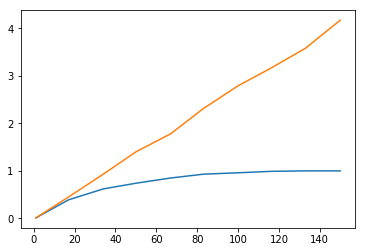

In [63]:
def calc_skills_coverage():
    xs=[]
    ys=[]
    ycnts=[]
    n_factors, min_active, max_active = 100,1,5
    n_students = 1
    tw=1
    a0=1
    a1=1
    max_n_qns = 150
    n_questions_list = numpy.linspace(1,max_n_qns,num=10).astype("int")

    _, _, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=max_n_qns)
    for n_questions in n_questions_list:
        cnt = numpy.array([False]*n_factors).astype("int")
#         plt.hist(qz_temp.flatten(), alpha=0.5)
#         plt.show()
        for q in qz_temp[0:n_questions]:
            active = (q > -10).astype("int")
#             print("a",active)
            cnt = cnt + active
            seen = numpy.clip(cnt, 0,1)
        print("c",cnt)
        print(n_questions, numpy.mean(seen), numpy.mean(cnt))
        xs.append(n_questions)
        ys.append(numpy.mean(seen))
        ycnts.append(numpy.mean(cnt))
    plt.plot(xs,ys)
    plt.plot(xs,ycnts)
    plt.show()
    
calc_skills_coverage()

In [15]:
gen_m_cache = pickle.load(open("generators.p", "rb"))

In [ ]:
gen_m_cache = {}

In [ ]:
tup = (100,100,100)
n_factors, min_active, max_active = tup

# sss = [10,20,30,50,70]
# nits = [1000,10000,50000]
sss = [70]
nits = [10000]


for ss in sss:
    for nit in nits:
        key = ((tup,(nit,ss)))
#         if key in gen_m_cache:
#             del gen_m_cache[key]
        print("creating genny")
        gen_m, history, best_dims, best_mse = create_offset_generator(n_factors, min_active, max_active, sampsize=ss, n_iter=nit)
        gen_m_cache[key] = (gen_m, history, best_dims, best_mse)

        # summarize history for loss
#         plt.plot(history.history['loss'])
#         plt.plot(history.history['val_loss'])
#         plt.title('Model loss for {}x{}'.format(ss,nit))
#         plt.ylabel('loss')
#         plt.xlabel('epoch')
#         plt.legend(['train', 'test'], loc='upper right')
#         plt.show()

In [ ]:
sss   = [10,20,30,50,70]
nits = [1000, 10000, 50000]
tup = (100,1,5)
for ss in sss:
    for nit in nits:
        key = ((tup,(nit,ss)))
        
        (gen_m, history, best_dims, best_mse) = gen_m_cache[key]
        # summarize history for loss
#         plt.plot(history.history['loss'])
#         plt.plot(history.history['val_loss'])
        print(key, best_dims, best_mse)
# plt.title('Model loss for {}x{}'.format(ss,nit))
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train {} {}'.format(ss,nit), 'test {} {}'.format(ss,nit)], loc='upper right')
# plt.show()

In [ ]:
xs = [10,20,30,50,70]
ys = [
    0.26942141892910004,
    0.12947245151996611,
    0.08696433037519455,
    0.051164472541213035,
    0.04078790558874607
] 
x2s = [x**2 for x in xs]
plt.figure(figsize=(6,4))
plt.plot(x2s, ys)
plt.title("Best model loss, 10000 samples ")
plt.xlabel("Data points per sample")
plt.ylabel("$J_{MSE}$")
plt.show()

In [ ]:
pickle.dump(gen_m_cache, open("generators.p", "wb"))

In [ ]:
from numpy.random import seed
from sklearn.model_selection import train_test_split

tup = (100,1,5)
key = (tup, (10000,70))

if key in gen_m_cache:
#     gen_m = gen_m_cache[tup]
    (gen_m, history, best_dims, best_mse) = gen_m_cache[key]
else:
    print(key)
    print(gen_m_cache.keys())
    raise Exception("Trying to use generator that does not exist")

factors_master = [tup]
w_list = [200]
factors_list = [ m+(w,) for m in factors_master for w in w_list ]

bal=0.5
explore_mode = False

distro_params = []
pfz_list = []

pfzz = None #numpy.array([])
lookup = {}

i=0
explore_mode=True
toomuch, toolittle, goldi = 0,0,0
for (n_factors, min_active, max_active, _) in factors_list:

    model_list=[]
    rasch=True

    questions=None

    qws_list = []
    sws_list = []
    tr_list = []
    params_list = []
    # questions=None
    real_stu_list=[]
    real_que_list=[]
    perseverance_list=[]
    test_datasets=[]

    pred_list = []

    found = False
    tensorflow.random.set_seed(666)
    seed(666)
    mode = "n"
    
    print(gen_m_cache.keys())
    
    for ss in sss:
        for nit in nits:
            tup = n_factors, min_active, max_active
            key = ((tup,(nit,ss)))
#             gen_m = gen_m_cache[key]
            (gen_m, history, best_dims, best_mse) = gen_m_cache[key]
            while i < 1:
                tw = random.uniform(0.5, 3.5)
                a1 = random.uniform(1, 3.5)
        #         a1 = random.uniform(1, 5)

                if mode=="n":
                    a0n = gen_m.predict(numpy.array([[tw,a1, bal]]).reshape(1,-1))
                else:
                    a0r = random.uniform(-1,8.7)

                print("gening data")
                _, probs, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=100, n_questions=100)

                print("run created")
                students2 = students_temp

            #     if questions is None:
                questions = qz_temp

        #                         qn_av = numpy.mean(questions, axis=0)
        #                         qn_std = numpy.std(questions, axis=0)

                if explore_mode:
                    plot_items([], questions, None)

                    bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

                    plt.hist(students2.flatten(), alpha=0.5, bins=bin_spread(students2))
                    plt.hist(questions.flatten(), alpha=0.5, bins=bin_spread(questions))
                    plt.show()

                obs=numpy.zeros((len(students2), len(questions)))
                pfz = probs.flatten()
                if pfzz is None:
                    pfzz = numpy.array(pfz)
                else:
                    numpy.concatenate((pfzz, pfz))

                if explore_mode:
                #     plt.hist(probs.flatten(), alpha=0.5)
                    plt.title("Histogram of $p_{pass}$")
                    plt.xlabel("$p_{pass}")
                    plt.ylabel("Frequency")
                    plt.legend()
                    plt.show()
                    plt.hist(pfz.flatten(), alpha=0.5)
                    plt.title("pfz")
                    plt.show()          

                hard = (probs >= 0.5)
                agt = 0 #numpy.zeros_like(probs)
                n_agt_runs = 10
                for _ in range(n_agt_runs):
                    this_obs  = (numpy.random.random(probs.shape) < probs).astype(int)
                    this_agt = numpy.mean((hard==this_obs).astype(int).flatten())
                    agt += this_agt / n_agt_runs
                print("*** AGT:", agt)                    

                print(tw, a1, a0)
                mn = numpy.mean(probs.flatten())
                if mn > 0.9:
                    toomuch+=1
                if mn < 0.1:
                    toolittle+=1
                if (mn < 0.6) and (mn > 0.4):
                    goldi +=1

        #         distro_params.append((vmn,agt))
                pfz_list.append(pfz)
                i+=1

        if explore_mode:
        #     plt.hist(probs.flatten(), alpha=0.5)
            plt.title("Histogram of $p_{pass}$")
            plt.xlabel("$p_{pass}")
            plt.ylabel("Frequency")
            plt.legend()
            plt.show()
            plt.hist(pfzz.flatten(), alpha=0.5)
            plt.title("pfz")
            plt.show()
        print(numpy.mean(pfzz), numpy.std(pfzz))
        print(toolittle, goldi, toomuch)

In [ ]:
from numpy.random import seed
from sklearn.model_selection import train_test_split

tup = (100,1,5)
key = (tup,(10000,70))
if tup in gen_m_cache:
    gen_m = gen_m_cache[tup]
else:
    raise Exception("Trying to use generator that does not exist")

factors_master = [tup]
w_list = [200]
factors_list = [ m+(w,) for m in factors_master for w in w_list ]

bal=0.500
explore_mode = False

distro_params = []


balance_lookup = {}


# for (n_factors, min_active, max_active, _) in factors_list:
bal_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for bal in bal_list:
    i=0
    model_list=[]
    rasch=True

    questions=None

    qws_list = []
    sws_list = []
    tr_list = []
    params_list = []
    # questions=None
    real_stu_list=[]
    real_que_list=[]
    perseverance_list=[]
    test_datasets=[]

    pred_list = []

    tensorflow.random.set_seed(666)
    seed(666)
    found = False
    
    probs_list = []
    pfz_list = []
    while i < 100:
        print("BAL target:", bal)
        tw = random.uniform(0.5, 3.5)
#                         a1 = random.uniform(1, 3.5)
        a1 = random.uniform(1, 3.5)
        a0 = gen_m.predict(numpy.array([[tw,a1, bal]]).reshape(1,-1))
#         a0 = random.uniform(-1,1.6)
#         a0 = random.uniform(-1,3.5)
 
        print("gening data")
        _, probs, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=100, n_questions=100)

        print("run created")
        students2 = students_temp

    #     if questions is None:
        questions = qz_temp

#                         qn_av = numpy.mean(questions, axis=0)
#                         qn_std = numpy.std(questions, axis=0)

        if explore_mode:
            plot_items([], questions, None)

            bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

            plt.hist(students2.flatten(), alpha=0.5, bins=bin_spread(students2))
            plt.hist(questions.flatten(), alpha=0.5, bins=bin_spread(questions))
            plt.show()

        obs=numpy.zeros((len(students2), len(questions)))

        all_pairs = []
        tr_pairs = []
        v_pairs = []
        tt_pairs = []
        perseverance = []
        slist = list(range(len(students2)))
        random.seed(666)
        shuffle(slist)
        for vi in slist:
#                             c=0
            p_cont = None #(n_students * n_questions)//5
            v_size = p_cont
            qlist= list(range(len(questions)))
            shuffle(qlist)
            first = True
            for mi in qlist:
                if first:
                    tt_pairs.append((vi,mi))
                    first = False
                else:
                    tr_pairs.append((vi,mi))

        print("splitting")
        tr_pairs, _ = train_test_split(tr_pairs, test_size=0.5, shuffle=False)
        tr_pairs, v_pairs = train_test_split(tr_pairs, test_size=0.1, shuffle=False)
        print("splut")

#                         print("scanning")
#                         for pa in tr_pairs:
# #                             print(pa)
#                             if pa in tt_pairs:
#                                 print("TR IN TT")
#                                 raise Exception
#                             if pa in v_pairs:
#                                 print("TR IN V")
#                                 raise Exception
#                         print("scun")

        pfz, sz, qz = stitch_n_split(tr_pairs, probs)
        vpfz, vsz, vqz = stitch_n_split(v_pairs, probs)

        print("lens of pfz and vpfz, tt_pairs", len(pfz), len(vpfz), len(tt_pairs))

#                         print(probs)

        hard = (probs >= 0.5)
        agt = 0 #numpy.zeros_like(probs)
        n_agt_runs = 10
        for _ in range(n_agt_runs):
            this_obs  = (numpy.random.random(probs.shape) < probs).astype(int)
            this_agt = numpy.mean((hard==this_obs).astype(int).flatten())
            agt += this_agt / n_agt_runs
        print("*** AGT:", agt)                            

        if explore_mode:
            plt.hist(probs.flatten(), alpha=0.5)
            plt.title("Histogram of $p_{pass}$")
            plt.xlabel("$p_{pass}")
            plt.ylabel("Frequency")
            plt.legend()
            plt.show()

            plt.hist(numpy.array(pfz).flatten(), alpha=0.5)
            plt.title("pfz")
            plt.show()


        print(tw, a1, a0)
        mn = numpy.mean(pfz)
        vmn = numpy.mean(vpfz)
        print(mn, vmn)

        distro_params.append((vmn,agt))
        pfz_list.append(pfz)
        probs_list.append(probs.flatten())
        
        i+=1
    balance_lookup[bal] = (probs_list, pfz_list)



In [ ]:
# plt.hist(numpy.array(probs_list).flatten())
# plt.title("Counts of pass probabilties (Raw params, 100 trials)")
# plt.xlabel("$p_{pass}$")
# plt.ylabel("Count")

bal_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for bal in bal_list:
    (probs_list, pfz_list) = balance_lookup[bal]
    mnz = [numpy.mean(pfz) for pfz in pfz_list]
    print(bal, numpy.mean(mnz))
#     print(mnz)
    
    #print(numpy.mean(pfz_list))
    print (numpy.sqrt(numpy.mean(numpy.power(numpy.subtract(mnz,bal), 2))))


In [ ]:
mnz2, agtz2 = zip(*distro_params)
print(mnz2)
mnz2 = numpy.array(mnz2).flatten()
print (numpy.mean(numpy.power(mnz2 - 0.5, 2)))
plt.hist((mnz2 - 0.5))
plt.show()
print (numpy.std((mnz2 - 0.5)))


In [ ]:
mnz, agtz = zip(*distro_params)
plt.xlim(0,1)
plt.hist(ub_mnz, label="Raw", alpha=0.3)
plt.hist(hd_mnz, label="Balanced (Grid search)", alpha=0.3)
plt.hist(mnz, label="Balanced (MLP)", alpha=1)
plt.title("Raw vs Balanced generated data (100 trials)")
plt.ylabel("Frequency")
plt.xlabel("Mean pass-rate of generated data, $\overline{p_{exp}}$")
plt.legend()
plt.show()

plt.hist(agtz)
plt.show()

summary_mnz = []
for pfz in pfz_list:
    mn = numpy.mean(pfz)
    summary_mnz.append(mn)
    plt.hist(pfz, alpha=.4)
plt.show()

print("Mean of means:", numpy.mean(summary_mnz))
print("Std of means:", numpy.std(summary_mnz))

In [21]:
from sklearn.metrics import r2_score, mean_absolute_error
def report(n_factors, min_active, max_active, emb_w, nn_mode, loss_mode, sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list, spars_list):
    
    tot_sqerr = 0
    mean_err_list = []
    mean_std_list = []
    mean_hit_list = []
    
    print("*****")
    print(nn_mode, loss_mode)
#     print("*****")
    print(len(sws_list), len(qws_list), len(model_list), len(real_stu_list), len(real_que_list), len(test_datasets), len(params_list))
    
    for sw,qw,m,stz,qnz,tt_pairs, params, spars in zip(sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list, spars_list):
        tw,a1,a0,trbal,vbal,agt = params
        
        print("params:", n_factors, min_active, max_active, emb_w, "/", tw,a1,a0, "(", trbal,vbal,agt,") [",spars,"]")
        
        err_list = []
        true_err_list = []
        hit_list = []
    #     for six,qix in numpy.sort(tt_pairs, axis=0):
    
        true_pz = []
        pred_pz = []
        for six, qix in tt_pairs:
    #         print(six, qix)
    #     print("\n------\n")
    #     continue
    #     if False:
            tq = qnz[qix,:]
            ts = stz[six,:]
            qrow = qw[qix, :]
            srow = sw[six, :]
#             print(qrow)
    #         print("raw",tq,ts)
    #         print("dif",ts-tq)
    #         print(numpy.prod(logistic(ts-tq,1,0)))
            if rasch:
                true_p = float(calc_probs_from_embs(ts.reshape(1,-1),tq.reshape(1,-1)))
#                 dif = ts-tq
#                 true_ps = 1.0 / (1.0 + numpy.exp(-dif))
#                 true_p = numpy.prod(true_ps)
            else:
                true_p = numpy.prod((1-tq)+(ts*tq))
            pred_p = m.predict([[qix],[six]])
            true_pz.append(float(true_p))
            pred_pz.append(float(pred_p))
    #         pred_p = random.random()
    
            mae = numpy.abs(true_p - pred_p)
#             print(true_p, float(pred_p), "err:", float(mae))

            err = true_p - pred_p

            true_err_list.append(err)
            err_list.append(mae)
            good_guess = int(numpy.round(true_p))==int(numpy.round(pred_p))
            hit_list.append(int(good_guess))
    #         sqerr = numpy.power(true_p - pred_p, 2)

#             print(six, qix, ":", srow, qrow)
#             print("-->", pred_p, true_p, " ... ", good_guess)

        print("R2 = ", r2_score(true_pz, pred_pz))
        print("MAE = ", mean_absolute_error(true_pz, pred_pz))
        numpy.set_printoptions(precision=3)
    #     print("Mean sq err {}:".format(qrow.shape), numpy.sqrt(numpy.mean(err_list)))
    
        plt.hist(true_pz, alpha=0.5)
        plt.hist(pred_pz, alpha=0.5)
        plt.show()
        
        plt.hist(numpy.array(true_err_list).flatten(), alpha=0.5)
        plt.show()
        
        mean_err_list.append(numpy.mean(err_list))
        mean_std_list.append(numpy.std(err_list))
        mean_hit_list.append(numpy.mean(hit_list))
    #     print(sum(hit_list), len(hit_list), sum(hit_list)/len(hit_list))

    # print(mean_err_list)
    # print(mean_std_list)
    # print(mean_hit_list)
    # print(params_list)
    print(len(stz),"x",len(qnz))
#     for e,s,acc,params in zip(mean_err_list, mean_std_list, mean_hit_list, params_list):
#         print("acc=",acc)
#         print("mae=",e,"sig=",s)
#         print(params)
#     print("aggregated:")
    print(numpy.median(mean_hit_list), numpy.std(mean_hit_list), "/", numpy.median(mean_err_list), numpy.median(mean_std_list))
    
# report(n_factors, min_active, max_active, emb_w, nn_mode, loss_mode, sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list)

In [17]:
data_cache = {}

10000 students, 200 questions
using datacache
run created
pred list shape (0,)
real items shape (200, 100)


/auto/homes/rjm49/.venvs/isaac36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/auto/homes/rjm49/.venvs/isaac36/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide
/auto/homes/rjm49/.venvs/isaac36/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in true_divide


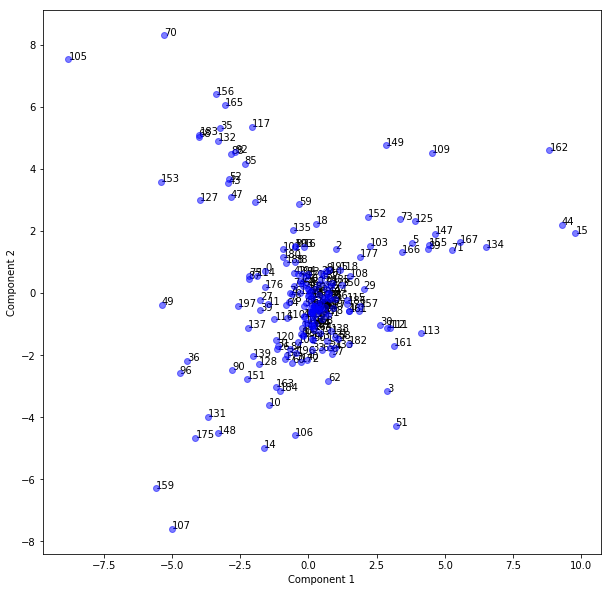

len Cs 0
Mean rand score = nan nan
~ ~ ~ ~~ ATTEMPT 0 [[2.079]]


/auto/homes/rjm49/.venvs/isaac36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/auto/homes/rjm49/.venvs/isaac36/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/auto/homes/rjm49/.venvs/isaac36/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/auto/homes/rjm49/.venvs/isaac36/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/auto/homes/rjm49/.venvs/isaac36/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


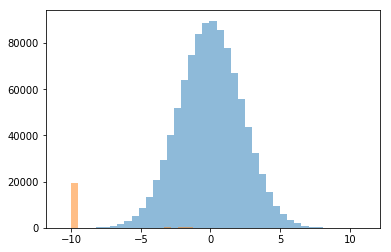

splitting
splut
[0.676 0.107 0.949 ... 0.981 0.777 0.4  ]
[0.676 0.107 0.949 ... 0.981 0.777 0.4  ]
[0 0 0 ... 0 0 0]
0 correctly labelled out of 1791000 %= 0.0
[0.308 0.914 0.153 ... 0.166 0.574 0.871]
[0.308 0.914 0.153 ... 0.166 0.574 0.871]
[0 0 0 ... 0 0 0]
0 correctly labelled out of 199000 %= 0.0
Sparsity 1.0 lens of pfz and vpfz, tt_pairs 1791000 199000 10000
[[0.454 0.803 0.593 ... 0.094 0.886 0.634]
 [0.007 0.886 0.083 ... 0.063 0.317 0.709]
 [0.527 0.804 0.035 ... 0.619 0.835 0.798]
 ...
 [0.465 0.534 0.387 ... 0.02  0.373 0.241]
 [0.26  0.421 0.159 ... 0.157 0.735 0.7  ]
 [0.891 0.486 0.2   ... 0.724 0.994 0.898]]
*** AGT: 0.7911066499999999


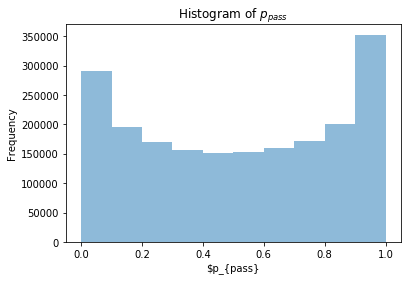

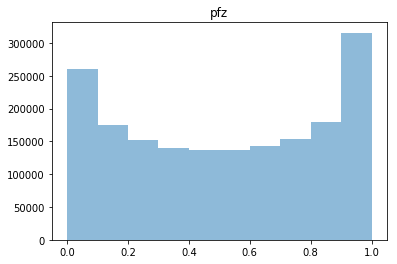

0.5636739213509128 4.2794227824212765 [[2.079]]
0.516223827849955 0.5157171235946164
xhxwx ELIGIBLE SPREAD for 0.516223827849955 0.5 0.55 0.45
FOUND ELIGIBLE SPREAD for 0.516223827849955 0.5 0.55 0.45
mean pers is nan
binary obs? False
callio:
1791000 1791000 1791000
199000 199000 199000 128
nn_mode DEEP
kk (200, 128)
selector shape (None, 1)
flat selector shape (None,)
call kk (200, 128)
'rows' shape, (None, 128)
kk (10000, 128)
selector shape (None, 1)
flat selector shape (None,)
call kk (10000, 128)
'rows' shape, (None, 128)
Mode is DEEP
loss mode is XENT
Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
psi_select (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
q_select (InputLayer)

/auto/homes/rjm49/.venvs/isaac36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1791000 samples, validate on 199000 samples
Epoch 1/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6962 - accuracy: 0.0000e+00 - val_loss: 0.6946 - val_accuracy: 0.0000e+00
Epoch 2/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6947 - accuracy: 0.0000e+00 - val_loss: 0.6926 - val_accuracy: 0.0000e+00
Epoch 3/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6926 - accuracy: 0.0000e+00 - val_loss: 0.6908 - val_accuracy: 0.0000e+00
Epoch 4/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6908 - accuracy: 0.0000e+00 - val_loss: 0.6890 - val_accuracy: 0.0000e+00
Epoch 5/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6890 - accuracy: 0.0000e+00 - val_loss: 0.6872 - val_accuracy: 0.0000e+00
Epoch 6/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6872 - accuracy: 0.0000e+00 - val_loss: 0.6854 - val_ac

Epoch 52/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6180 - accuracy: 0.0000e+00 - val_loss: 0.6202 - val_accuracy: 0.0000e+00
Epoch 53/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6178 - accuracy: 0.0000e+00 - val_loss: 0.6200 - val_accuracy: 0.0000e+00
Epoch 54/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6177 - accuracy: 0.0000e+00 - val_loss: 0.6199 - val_accuracy: 0.0000e+00
Epoch 55/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6175 - accuracy: 0.0000e+00 - val_loss: 0.6198 - val_accuracy: 0.0000e+00
Epoch 56/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6174 - accuracy: 0.0000e+00 - val_loss: 0.6197 - val_accuracy: 0.0000e+00
Epoch 57/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6173 - accuracy: 0.0000e+00 - val_loss: 0.6196 - val_accuracy: 0.0000e+00
Epoch 58/10000
1791000/17910

Epoch 103/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6149 - accuracy: 0.0000e+00 - val_loss: 0.6190 - val_accuracy: 0.0000e+00
Epoch 104/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6149 - accuracy: 0.0000e+00 - val_loss: 0.6190 - val_accuracy: 0.0000e+00
Epoch 105/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6148 - accuracy: 0.0000e+00 - val_loss: 0.6190 - val_accuracy: 0.0000e+00
Epoch 106/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6148 - accuracy: 0.0000e+00 - val_loss: 0.6190 - val_accuracy: 0.0000e+00
Epoch 107/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6147 - accuracy: 0.0000e+00 - val_loss: 0.6190 - val_accuracy: 0.0000e+00
Epoch 108/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6147 - accuracy: 0.0000e+00 - val_loss: 0.6190 - val_accuracy: 0.0000e+00
Epoch 109/10000
179100

Epoch 154/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6119 - accuracy: 0.0000e+00 - val_loss: 0.6181 - val_accuracy: 0.0000e+00
Epoch 155/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6119 - accuracy: 0.0000e+00 - val_loss: 0.6180 - val_accuracy: 0.0000e+00
Epoch 156/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6118 - accuracy: 0.0000e+00 - val_loss: 0.6180 - val_accuracy: 0.0000e+00
Epoch 157/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6117 - accuracy: 0.0000e+00 - val_loss: 0.6180 - val_accuracy: 0.0000e+00
Epoch 158/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6116 - accuracy: 0.0000e+00 - val_loss: 0.6179 - val_accuracy: 0.0000e+00
Epoch 159/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6115 - accuracy: 0.0000e+00 - val_loss: 0.6179 - val_accuracy: 0.0000e+00
Epoch 160/10000
179100

Epoch 205/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6061 - accuracy: 0.0000e+00 - val_loss: 0.6152 - val_accuracy: 0.0000e+00
Epoch 206/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6059 - accuracy: 0.0000e+00 - val_loss: 0.6152 - val_accuracy: 0.0000e+00
Epoch 207/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6058 - accuracy: 0.0000e+00 - val_loss: 0.6151 - val_accuracy: 0.0000e+00
Epoch 208/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6056 - accuracy: 0.0000e+00 - val_loss: 0.6150 - val_accuracy: 0.0000e+00
Epoch 209/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6055 - accuracy: 0.0000e+00 - val_loss: 0.6149 - val_accuracy: 0.0000e+00
Epoch 210/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.6053 - accuracy: 0.0000e+00 - val_loss: 0.6148 - val_accuracy: 0.0000e+00
Epoch 211/10000
179100

Epoch 256/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5960 - accuracy: 0.0000e+00 - val_loss: 0.6105 - val_accuracy: 0.0000e+00
Epoch 257/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5958 - accuracy: 0.0000e+00 - val_loss: 0.6104 - val_accuracy: 0.0000e+00
Epoch 258/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5955 - accuracy: 0.0000e+00 - val_loss: 0.6103 - val_accuracy: 0.0000e+00
Epoch 259/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5953 - accuracy: 0.0000e+00 - val_loss: 0.6102 - val_accuracy: 0.0000e+00
Epoch 260/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5950 - accuracy: 0.0000e+00 - val_loss: 0.6101 - val_accuracy: 0.0000e+00
Epoch 261/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5948 - accuracy: 0.0000e+00 - val_loss: 0.6100 - val_accuracy: 0.0000e+00
Epoch 262/10000
179100

Epoch 307/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5822 - accuracy: 0.0000e+00 - val_loss: 0.6046 - val_accuracy: 0.0000e+00
Epoch 308/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5819 - accuracy: 0.0000e+00 - val_loss: 0.6045 - val_accuracy: 0.0000e+00
Epoch 309/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5816 - accuracy: 0.0000e+00 - val_loss: 0.6044 - val_accuracy: 0.0000e+00
Epoch 310/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5813 - accuracy: 0.0000e+00 - val_loss: 0.6043 - val_accuracy: 0.0000e+00
Epoch 311/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5810 - accuracy: 0.0000e+00 - val_loss: 0.6042 - val_accuracy: 0.0000e+00
Epoch 312/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5807 - accuracy: 0.0000e+00 - val_loss: 0.6040 - val_accuracy: 0.0000e+00
Epoch 313/10000
179100

Epoch 358/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5670 - accuracy: 0.0000e+00 - val_loss: 0.5986 - val_accuracy: 0.0000e+00
Epoch 359/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5667 - accuracy: 0.0000e+00 - val_loss: 0.5985 - val_accuracy: 0.0000e+00
Epoch 360/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5664 - accuracy: 0.0000e+00 - val_loss: 0.5984 - val_accuracy: 0.0000e+00
Epoch 361/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5661 - accuracy: 0.0000e+00 - val_loss: 0.5983 - val_accuracy: 0.0000e+00
Epoch 362/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5658 - accuracy: 0.0000e+00 - val_loss: 0.5982 - val_accuracy: 0.0000e+00
Epoch 363/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5655 - accuracy: 0.0000e+00 - val_loss: 0.5981 - val_accuracy: 0.0000e+00
Epoch 364/10000
179100

Epoch 409/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5527 - accuracy: 0.0000e+00 - val_loss: 0.5930 - val_accuracy: 0.0000e+00
Epoch 410/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5524 - accuracy: 0.0000e+00 - val_loss: 0.5929 - val_accuracy: 0.0000e+00
Epoch 411/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5521 - accuracy: 0.0000e+00 - val_loss: 0.5928 - val_accuracy: 0.0000e+00
Epoch 412/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5519 - accuracy: 0.0000e+00 - val_loss: 0.5927 - val_accuracy: 0.0000e+00
Epoch 413/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5516 - accuracy: 0.0000e+00 - val_loss: 0.5926 - val_accuracy: 0.0000e+00
Epoch 414/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5513 - accuracy: 0.0000e+00 - val_loss: 0.5925 - val_accuracy: 0.0000e+00
Epoch 415/10000
179100

Epoch 460/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5397 - accuracy: 0.0000e+00 - val_loss: 0.5880 - val_accuracy: 0.0000e+00
Epoch 461/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5394 - accuracy: 0.0000e+00 - val_loss: 0.5879 - val_accuracy: 0.0000e+00
Epoch 462/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5392 - accuracy: 0.0000e+00 - val_loss: 0.5878 - val_accuracy: 0.0000e+00
Epoch 463/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5390 - accuracy: 0.0000e+00 - val_loss: 0.5877 - val_accuracy: 0.0000e+00
Epoch 464/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5387 - accuracy: 0.0000e+00 - val_loss: 0.5876 - val_accuracy: 0.0000e+00
Epoch 465/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5385 - accuracy: 0.0000e+00 - val_loss: 0.5875 - val_accuracy: 0.0000e+00
Epoch 466/10000
179100

Epoch 511/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5281 - accuracy: 0.0000e+00 - val_loss: 0.5834 - val_accuracy: 0.0000e+00
Epoch 512/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5279 - accuracy: 0.0000e+00 - val_loss: 0.5833 - val_accuracy: 0.0000e+00
Epoch 513/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5277 - accuracy: 0.0000e+00 - val_loss: 0.5832 - val_accuracy: 0.0000e+00
Epoch 514/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5275 - accuracy: 0.0000e+00 - val_loss: 0.5831 - val_accuracy: 0.0000e+00
Epoch 515/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5273 - accuracy: 0.0000e+00 - val_loss: 0.5831 - val_accuracy: 0.0000e+00
Epoch 516/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5271 - accuracy: 0.0000e+00 - val_loss: 0.5830 - val_accuracy: 0.0000e+00
Epoch 517/10000
179100

Epoch 562/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5182 - accuracy: 0.0000e+00 - val_loss: 0.5796 - val_accuracy: 0.0000e+00
Epoch 563/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5180 - accuracy: 0.0000e+00 - val_loss: 0.5795 - val_accuracy: 0.0000e+00
Epoch 564/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5179 - accuracy: 0.0000e+00 - val_loss: 0.5794 - val_accuracy: 0.0000e+00
Epoch 565/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5177 - accuracy: 0.0000e+00 - val_loss: 0.5793 - val_accuracy: 0.0000e+00
Epoch 566/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5175 - accuracy: 0.0000e+00 - val_loss: 0.5793 - val_accuracy: 0.0000e+00
Epoch 567/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5173 - accuracy: 0.0000e+00 - val_loss: 0.5792 - val_accuracy: 0.0000e+00
Epoch 568/10000
179100

Epoch 613/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5099 - accuracy: 0.0000e+00 - val_loss: 0.5762 - val_accuracy: 0.0000e+00
Epoch 614/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5097 - accuracy: 0.0000e+00 - val_loss: 0.5762 - val_accuracy: 0.0000e+00
Epoch 615/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5096 - accuracy: 0.0000e+00 - val_loss: 0.5761 - val_accuracy: 0.0000e+00
Epoch 616/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5094 - accuracy: 0.0000e+00 - val_loss: 0.5761 - val_accuracy: 0.0000e+00
Epoch 617/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5093 - accuracy: 0.0000e+00 - val_loss: 0.5760 - val_accuracy: 0.0000e+00
Epoch 618/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5091 - accuracy: 0.0000e+00 - val_loss: 0.5760 - val_accuracy: 0.0000e+00
Epoch 619/10000
179100

Epoch 664/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5030 - accuracy: 0.0000e+00 - val_loss: 0.5739 - val_accuracy: 0.0000e+00
Epoch 665/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5029 - accuracy: 0.0000e+00 - val_loss: 0.5739 - val_accuracy: 0.0000e+00
Epoch 666/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5028 - accuracy: 0.0000e+00 - val_loss: 0.5739 - val_accuracy: 0.0000e+00
Epoch 667/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5027 - accuracy: 0.0000e+00 - val_loss: 0.5738 - val_accuracy: 0.0000e+00
Epoch 668/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5026 - accuracy: 0.0000e+00 - val_loss: 0.5738 - val_accuracy: 0.0000e+00
Epoch 669/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.5024 - accuracy: 0.0000e+00 - val_loss: 0.5737 - val_accuracy: 0.0000e+00
Epoch 670/10000
179100

Epoch 715/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4976 - accuracy: 0.0000e+00 - val_loss: 0.5723 - val_accuracy: 0.0000e+00
Epoch 716/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4975 - accuracy: 0.0000e+00 - val_loss: 0.5723 - val_accuracy: 0.0000e+00
Epoch 717/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4974 - accuracy: 0.0000e+00 - val_loss: 0.5722 - val_accuracy: 0.0000e+00
Epoch 718/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4973 - accuracy: 0.0000e+00 - val_loss: 0.5722 - val_accuracy: 0.0000e+00
Epoch 719/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4972 - accuracy: 0.0000e+00 - val_loss: 0.5722 - val_accuracy: 0.0000e+00
Epoch 720/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4971 - accuracy: 0.0000e+00 - val_loss: 0.5722 - val_accuracy: 0.0000e+00
Epoch 721/10000
179100

Epoch 766/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4934 - accuracy: 0.0000e+00 - val_loss: 0.5711 - val_accuracy: 0.0000e+00
Epoch 767/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4933 - accuracy: 0.0000e+00 - val_loss: 0.5711 - val_accuracy: 0.0000e+00
Epoch 768/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4932 - accuracy: 0.0000e+00 - val_loss: 0.5710 - val_accuracy: 0.0000e+00
Epoch 769/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4931 - accuracy: 0.0000e+00 - val_loss: 0.5710 - val_accuracy: 0.0000e+00
Epoch 770/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4931 - accuracy: 0.0000e+00 - val_loss: 0.5710 - val_accuracy: 0.0000e+00
Epoch 771/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4930 - accuracy: 0.0000e+00 - val_loss: 0.5710 - val_accuracy: 0.0000e+00
Epoch 772/10000
179100

Epoch 817/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4901 - accuracy: 0.0000e+00 - val_loss: 0.5703 - val_accuracy: 0.0000e+00
Epoch 818/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4900 - accuracy: 0.0000e+00 - val_loss: 0.5703 - val_accuracy: 0.0000e+00
Epoch 819/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4899 - accuracy: 0.0000e+00 - val_loss: 0.5702 - val_accuracy: 0.0000e+00
Epoch 820/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4899 - accuracy: 0.0000e+00 - val_loss: 0.5702 - val_accuracy: 0.0000e+00
Epoch 821/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4898 - accuracy: 0.0000e+00 - val_loss: 0.5702 - val_accuracy: 0.0000e+00
Epoch 822/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4898 - accuracy: 0.0000e+00 - val_loss: 0.5702 - val_accuracy: 0.0000e+00
Epoch 823/10000
179100

Epoch 868/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4875 - accuracy: 0.0000e+00 - val_loss: 0.5699 - val_accuracy: 0.0000e+00
Epoch 869/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4874 - accuracy: 0.0000e+00 - val_loss: 0.5698 - val_accuracy: 0.0000e+00
Epoch 870/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4874 - accuracy: 0.0000e+00 - val_loss: 0.5699 - val_accuracy: 0.0000e+00
Epoch 871/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4873 - accuracy: 0.0000e+00 - val_loss: 0.5698 - val_accuracy: 0.0000e+00
Epoch 872/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4873 - accuracy: 0.0000e+00 - val_loss: 0.5699 - val_accuracy: 0.0000e+00
Epoch 873/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4872 - accuracy: 0.0000e+00 - val_loss: 0.5698 - val_accuracy: 0.0000e+00
Epoch 874/10000
179100

Epoch 919/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4854 - accuracy: 0.0000e+00 - val_loss: 0.5696 - val_accuracy: 0.0000e+00
Epoch 920/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4854 - accuracy: 0.0000e+00 - val_loss: 0.5696 - val_accuracy: 0.0000e+00
Epoch 921/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4853 - accuracy: 0.0000e+00 - val_loss: 0.5696 - val_accuracy: 0.0000e+00
Epoch 922/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4853 - accuracy: 0.0000e+00 - val_loss: 0.5696 - val_accuracy: 0.0000e+00
Epoch 923/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4852 - accuracy: 0.0000e+00 - val_loss: 0.5696 - val_accuracy: 0.0000e+00
Epoch 924/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4852 - accuracy: 0.0000e+00 - val_loss: 0.5695 - val_accuracy: 0.0000e+00
Epoch 925/10000
179100

Epoch 970/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4837 - accuracy: 0.0000e+00 - val_loss: 0.5694 - val_accuracy: 0.0000e+00
Epoch 971/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4837 - accuracy: 0.0000e+00 - val_loss: 0.5694 - val_accuracy: 0.0000e+00
Epoch 972/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4837 - accuracy: 0.0000e+00 - val_loss: 0.5694 - val_accuracy: 0.0000e+00
Epoch 973/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4836 - accuracy: 0.0000e+00 - val_loss: 0.5694 - val_accuracy: 0.0000e+00
Epoch 974/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4836 - accuracy: 0.0000e+00 - val_loss: 0.5694 - val_accuracy: 0.0000e+00
Epoch 975/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4836 - accuracy: 0.0000e+00 - val_loss: 0.5694 - val_accuracy: 0.0000e+00
Epoch 976/10000
179100

Epoch 1021/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4823 - accuracy: 0.0000e+00 - val_loss: 0.5693 - val_accuracy: 0.0000e+00
Epoch 1022/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4823 - accuracy: 0.0000e+00 - val_loss: 0.5693 - val_accuracy: 0.0000e+00
Epoch 1023/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4823 - accuracy: 0.0000e+00 - val_loss: 0.5693 - val_accuracy: 0.0000e+00
Epoch 1024/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4823 - accuracy: 0.0000e+00 - val_loss: 0.5693 - val_accuracy: 0.0000e+00
Epoch 1025/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4822 - accuracy: 0.0000e+00 - val_loss: 0.5693 - val_accuracy: 0.0000e+00
Epoch 1026/10000
1791000/1791000 [==============================] - 2s 1us/step - loss: 0.4822 - accuracy: 0.0000e+00 - val_loss: 0.5693 - val_accuracy: 0.0000e+00
Epoch 1027/10000

In [82]:
#tw should be ~U[0.5, 3.5]
#sw should be ~N[0, sd] with sd ~U[1, 3.5]
#a0 should be ~U[-0.5, 1]
#missing proportion should be ~U[0, 0.3]

# from tensorflow.random import set_seed
from sklearn.model_selection import train_test_split

explore_mode = True

reportz=[]

# factors_master = [(10,1,5)]
factors_master = [(100,1,5)]
w_list = [128]
factors_list = [ m+(w,) for m in factors_master for w in w_list ]

# nn_modes = ["MLTM","COND","MXFN"]
nn_modes = ["DEEP"]
loss_modes = ["XENT"]
# sq_nums = [(int(1000*(1.4)**3), int(150*(1.4)**3))]
sq_nums = [(10000, 200)]
# sq_nums = [(10000, 150)]
# student_staminas = [0.01, 0.1, 0.5, 0.75, 1.0]

spars_list = [1.0] # [0.01, 0.05, 0.25, 0.5, 0.75, 1.0]

n_runs = 1
bal = .5

for (n_students, n_questions) in sq_nums:
    print("{} students, {} questions".format(n_students, n_questions))
    for nn_mode in nn_modes:
        for loss_mode in loss_modes:
            for (n_factors, min_active, max_active, emb_w) in factors_list:
                for spars in spars_list:

                    model_list=[]
                    rasch=True

                    questions=None

                    tup = ((n_factors, min_active, max_active), (10000, 70))
                    if tup in gen_m_cache:
                        (gen_m, history, best_dims, best_mse) = gen_m_cache[tup]
                    else:
                        print(gen_m_cache.keys())
                        raise Exception("Genny not found for",tup)
                    
                    qws_list = []
                    sws_list = []
                    tr_list = []
                    params_list = []
                    # questions=None
                    real_stu_list=[]
                    real_que_list=[]
                    perseverance_list=[]
                    test_datasets=[]
                    sparss = []
    #                 qn_av = None
    #                 qn_std = None

                    pred_list = []

#                     set_seed(666)
                    numpy.random.seed(666)
                    for a in range(n_runs):

                        found = False
                        while not found:
                            tw = random.uniform(0.5, 3.5)
    #                         a1 = random.uniform(1, 3.5)
                            a1 = random.uniform(1, 5)
                            a0 = gen_m.predict(numpy.array([[tw,a1, bal]]).reshape(1,-1))

                            gen_new_data = False
                            if rasch:
                                if tup not in data_cache:
                                    print("Not data in cache for desired shape")
                                    gen_new_data = True
                                else:
                                    print("using datacache")
                                    (probs, students_temp, qz_temp) = data_cache[tup]
                                    if students_temp.shape != (n_students, n_factors) or qz_temp.shape!=(n_questions, n_factors):
                                        print("data shape has changed, need to make new data")
                                        gen_new_data = True
                                
                                if gen_new_data:
                                    print("gening data")
                                    _, probs, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=n_questions)
                                

                                
                            print("run created")
                            students2 = students_temp
                            questions = qz_temp

                            if explore_mode:
                                plot_items([], questions, None)

                                print("~ ~ ~ ~~ ATTEMPT",a, a0)
                                bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

                                plt.hist(students2.flatten(), alpha=0.5, bins=bin_spread(students2))
                                plt.hist(questions.flatten(), alpha=0.5, bins=bin_spread(questions))
                                plt.show()

                        #     (sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2), obs2, probs2 = tvt_split(students2, questions, split_mode=1)
                        #     tr_list.append(((sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2)))


    #                         probs=numpy.zeros((len(students2), len(questions)))
                            obs=numpy.zeros((len(students2), len(questions)))

                            all_pairs = []
                            tr_pairs = []
                            v_pairs = []
                            tt_pairs = []
                            perseverance = []
                            slist = list(range(len(students2)))
                            random.seed(666)
                            shuffle(slist)
                            for vi in slist:
    #                             c=0
    #                             p_cont = (n_students * n_questions)//20
    #                             v_size = p_cont
                                qlist= list(range(len(questions)))
                                shuffle(qlist)
                                first = True
                                for mi in qlist:
                                    if first:
                                        tt_pairs.append((vi,mi))
                                        first = False
                                    else:
                                        tr_pairs.append((vi,mi))

                            print("splitting")
                            if spars < 1:
                                tr_pairs, _ = train_test_split(tr_pairs, train_size=spars)
                            tr_pairs, v_pairs = train_test_split(tr_pairs, test_size=0.1)
                            print("splut")

#                             print("scanning")
#                             for pa in tr_pairs:
#     #                             print(pa)
#                                 if pa in tt_pairs:
#                                     print("TR IN TT")
#                                     raise Exception
#                                 if pa in v_pairs:
#                                     print("TR IN V")
#                                     raise Exception
#                             print("scun")

    #                         print("tr_pairs", tr_pairs)
                            pfz, sz, qz = stitch_n_split(tr_pairs, probs)
                            vpfz, vsz, vqz = stitch_n_split(v_pairs, probs)
#                             vpfz, vsz, vqz = [],[],[]

                            print("Sparsity",spars,"lens of pfz and vpfz, tt_pairs", len(pfz), len(vpfz), len(tt_pairs))

                            print(probs)

                            hard =numpy.round(probs)
                            agt = 0 #numpy.zeros_like(probs)
                            n_agt_runs = 10
                            for _ in range(n_agt_runs):
                                this_obs  = (numpy.random.random(probs.shape) < probs).astype(int)
                                this_agt = numpy.mean((hard==this_obs).astype(int).flatten())
                                agt += this_agt / n_agt_runs
                            print("*** AGT:", agt)                            

                            if explore_mode:
                                plt.hist(probs.flatten(), alpha=0.5)
                                plt.title("Histogram of $p_{pass}$")
                                plt.xlabel("$p_{pass}")
                                plt.ylabel("Frequency")
                                plt.legend()
                                plt.show()

                                plt.hist(numpy.array(pfz).flatten(), alpha=0.5)
                                plt.title("pfz")
                                plt.show()


                            print(tw, a1, a0)
                            mn = numpy.mean(pfz)
                            print(mn, numpy.mean(vpfz))
                            uppa = bal+0.05
                            lowa = bal-0.05
                            print("xhxwx ELIGIBLE SPREAD for",mn,bal, uppa, lowa)
                            if (mn >= lowa) and (mn <= uppa):
                                print("FOUND ELIGIBLE SPREAD for",mn,bal, uppa, lowa)
                                data_cache[tup] = (probs, students_temp, qz_temp)
                                found=True

                        hard=None
                        probs=None

                        print("mean pers is", numpy.mean(perseverance))
                        perseverance_list.append(perseverance)
                        real_stu_list.append(students2)
                        real_que_list.append(questions)
                        test_datasets.append(tt_pairs)
                        params_list.append((tw,a1,a0,numpy.mean(pfz), numpy.mean(vpfz), agt))
                    #     if numpy.mean(pfz) <0.4 or numpy.mean(pfz)>0.6:
                    #         continue

                    # for runix in range(n_runs):
                    #     (sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2) = tr_list[runix]
                        obs_are_binary = numpy.array_equal(numpy.array(pfz).flatten(), numpy.array(pfz).flatten().astype(bool))
                        print("binary obs?", obs_are_binary)

                        print("callio:")
                        print(len(qz),len(sz),len(pfz))
                        print(len(vqz),len(vsz),len(vpfz), emb_w)
    #                     nn_mode = "MLTM"
    #                     loss_mode = "XENT"
                        print("nn_mode", nn_mode)
                        s_table2, qn_table2, m2, h2 = generate_and_train(n_students, n_questions, qz,sz,pfz, vqz,vsz,vpfz, emb_w, n_factors, min_active, max_active, nn_mode=nn_mode, loss_mode=loss_mode)
    #                     qws2= copy.copy(qn_table2.get_weights()[0])
    #                     sws2= copy.copy(s_table2.get_weights()[0])
                        qws2= qn_table2.get_weights()[0]
                        sws2= s_table2.get_weights()[0]

                        pred_probs = m2.predict([qz, sz])
    #                     print(pred_probs)
                        pred_list.append(pred_probs)
                        model_list.append(m2)

                    #     qg = q_gates.get_weights()[0]
                    #     qg_list.append(qg)
                    #     if qn_av is None:
                    #         qn_av = numpy.mean(qws2)

                        sparss.append(spars)
                        sws_list.append(sws2)
                        qws_list.append(qws2)
                    tup = (n_factors, min_active, max_active, emb_w, nn_mode, loss_mode, sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list, sparss)
    #                 reportz.append(zlib.compress(pickle.dumps(tup)))
    #                 print(perseverance_list)

                    reportz.append(tup)
print("finished")

*****
DEEP XENT
1 1 1 1 1 1 1
params: 100 1 5 128 / 0.5636739213509128 4.2794227824212765 [[2.079]] ( 0.516223827849955 0.5157171235946164 0.7911066499999999 ) [ 1.0 ]
R2 =  0.424600231408099
MAE =  0.18511217531097632


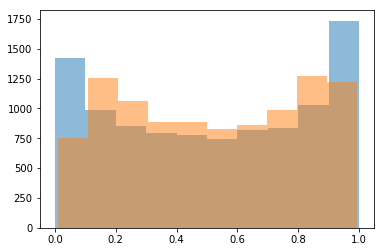

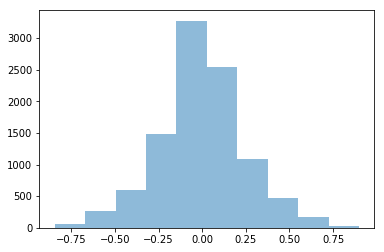

10000 x 200
0.7566 0.0 / 0.18511218 0.1640905


In [80]:
for tup in reportz:
#     tup = pickle.loads(zlib.decompress(tup_cmp))
    report(*tup)
    
# qws = reportz[0][7][0]
# real_qws = reportz[0][10][0]
# print(qws)
# numpy.set_printoptions(threshold=10000)
# print(real_qws)

# *****
# MLTM XENT
# 1 1 1 1 1 1 1
# params: 10 1 5 1 / 2.5806077740610034 2.347493116108512 [[ 0.821]] 0.459641891892 0.495
# R2 =  0.447788537896
# MAE =  0.204465762654
# 1000 x 150
# 0.749 0.0 / 0.204466 0.144075




In [ ]:
# sws2= s_table2.get_weights()[0]
# qws2= qn_table2.get_weights()[0]

# offset = numpy.mean(students2) - numpy.mean(sws2) 
# qws2 = qws2# + offset
# sws2 = sws2# + offset

bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

for ss in real_stu_list:
    plt.hist(ss.flatten(), alpha=0.2, bins=bin_spread(ss), label="s true")
# plt.legend()
# plt.show()

print("There are {} els in sws_list and {} els in qws_list".format(len(sws_list), len(qws_list)))

sw_av_list = []
for sw in sws_list:
#     (sz,qz,pfz), (vsz,vqz,vpfz), (tsz,tqz,tpfz) = tups
    plt.hist(sw.flatten(), alpha=0.2, bins=bin_spread(sw), label="s pred")
    sw_av_list.append(numpy.median(sw.flatten()))
plt.legend()
plt.show()

for qnz in real_que_list:
    plt.hist(qnz.flatten(), alpha=0.2, label="q true", bins=bin_spread(questions))

# qws_list_2 = []
real_max_q = numpy.max(questions.flatten())
print("len qws_list", len(qws_list))

for qw in qws_list:#, sw_av_list):
    qw = copy.copy(qw)
    print("med",numpy.median(qw), "for shape", qw.shape)
#     (sz,qz,pfz), (vsz,vqz,vpfz), (tsz,tqz,tpfz) = tups
#     qg2 = (qg>0.5).astype(int)
#     masqd = qw*qg2
#     qws_list_2.append(masqd)
#     print(qw)
#     print(qg)
#     plt.hist(qw[list(set(qz))].flatten(), alpha=0.4, bins=bin_spread(qw)) 

#     max_q = numpy.max(qw)
#     os = real_max_q - max_q
#     qw += os

#     thresh = 0
#     qw[qw < thresh] = 0
    plt.hist(qw.flatten(), alpha=0.2, label="q pred", bins=bin_spread(qw))
plt.legend()
plt.show()


# qws_list = qws_list2

print(len(pred_list))
plt.hist(pfz, alpha=0.2, label="true obs")
plt.hist(probs.flatten(), alpha=0.3, label="true probs")
for ix,predz in enumerate(pred_list):
    plt.hist(predz, alpha=0.1, label=str(ix))
plt.legend()
plt.show()

In [ ]:
plot_items(qws_list[1:], qws_list[0], 0)

In [ ]:
for qw in qws_list:#, sw_av_list):
    print(qw)

In [ ]:
def mean_ensemble(ref, pred_list):
    summage = numpy.zeros_like(ref)
    for items in pred_list:
        items_aligned, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, ref, items, max_iter=10)        
        print("err", numpy.mean(numpy.abs(items_aligned - ref)))
        summage += items_aligned
    summage /= len(pred_list)
    print("ensem err", numpy.mean(numpy.abs(summage - ref)))
    return summage
#         for item, real_item in zip(items, real_items):
#             print(numpy.sort(real_item))
#             print(numpy.sort(item))
#             print()
            

mean_en = mean_ensemble(qws_list[0], qws_list[1:])
plot_items([], questions, None)
plot_items(qws_list, mean_en, 0)


In [ ]:
print(m_list)
for m,tr in zip(m_list, tr_list):
    (sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2) = tr
    print(sz2,qz2,pfz2)
    print(vsz2,vqz2,vpfz2)
    print(tsz2,tqz2,tpfz2)
    preds = m.predict(x=[qz2,sz2])
    for sc_true, sc_hat in zip(pfz2,preds):
        print(sc_true, sc_hat)

    # print(m.evaluate(x=[mz,vz], y=scz))
    from sklearn.metrics import mean_absolute_error, mean_absolute_error
    print(mean_absolute_error(numpy.around(pfz2), numpy.around(preds)  ))
    
plt.hist(pfz2)
plt.show()
plt.hist(preds)
plt.show()

In [ ]:
from keras.callbacks import EarlyStopping
min_loss = math.inf
min_v_loss = math.inf
init_patience = 5
for i in range(100):
    print("shiteration i=",i)
    h = m.fit(x=[mz,vz], y=scz, batch_size=1000, epochs=2, shuffle=True, validation_split=1000/len(scz), verbose=1)
    val_loss = h.history["val_loss"][-1]
    loss = h.history["loss"][-1]
    if loss < min_loss and val_loss <= min_v_loss:
        min_v_loss = val_loss
        min_loss = loss
        print("patience reset")
        patience = init_patience
#         sw = s_table.get_weights()
#         qw = qn_table.get_weights()
    else:
        patience -= 1
    if patience==0:
        print("DONE")
        break
#     m.fit(x=[mz,vz], y=numpy.array([(0.5+random.uniform(-0.5,0.5)) for _ in scz]).reshape(-1,1), batch_size=1000, shuffle=False, epochs=10, verbose=0)
    m.fit(x=[mz,vz], y=numpy.array([0.5 for _ in scz]).reshape(-1,1), batch_size=1000, shuffle=False, epochs=2, verbose=0)
    
# s_table.set_weights(sw)
# qn_table.set_weights(qw)

In [ ]:
es = EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=10)
m.fit(x=[mz,vz], y=scz, batch_size=1000, epochs=100, validation_split=1000/len(scz))#, callbacks=[es])

In [ ]:
preds = m.predict(x=[tmz,tvz])
for p, sc_obsv, sc_hat in zip(t_probz, tscz,preds):
    print(p, sc_obsv, sc_hat, (numpy.around(sc_obsv)==numpy.around(sc_hat)))

# print(m.evaluate(x=[tmz,tvz], y=tscz))
from sklearn.metrics import accuracy_score, mean_absolute_error

print("obvsd acc", accuracy_score(numpy.around(tscz), numpy.around(preds)))
print("non-stoch acc", accuracy_score(numpy.around(t_probz), numpy.around(preds)))
print(mean_absolute_error(t_probz, preds))
#0.000302638761699 MSE MxMul


In [ ]:
    plt.hist(obs.flatten())
    plt.show()
    print(numpy.sum(numpy.around(obs)))
    print(len(obs.flatten()))
    

In [ ]:
pred_wgts = qn_table.get_weights()[0]
real_wgts = movies

split = 0

items_chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, real_wgts, pred_wgts, max_iter=10)

In [ ]:
print(min_total_err, total_q_err, total_s_err)

print(items_chosen)



In [ ]:
## fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
# pca = TSNE(n_components=2)

itemz_pred = items_chosen
n = len(items_chosen)
itemz = movies

# s_pred_mean = numpy.mean(s_table.get_weights()[0])
base = min( numpy.min(itemz_pred), numpy.min(itemz))
# ss1 = StandardScaler()
# itemz_pred = ss1.fit_transform(itemz_pred)
# itemz = ss1.transform(movies)

itemz = itemz - base
itemz_pred = itemz_pred - base

print(itemz)
print(itemz_pred)

In [ ]:
# itemz_pred = pca.transform(itemz_pred)

itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
# itemz_2 = itemz
itemz_2 = pca.fit_transform(itemz_2)

# itemz_2 = MinMaxScaler().fit_transform(itemz_2)

# ixes = itemz_pred < baseline
# itemz_pred[ixes] = (baseline-1)
# itemz_pred = itemz_pred - (baseline-1)
# itemz_pred = MinMaxScaler().fit_transform(itemz_pred)
# print(itemz_2)

# fig,axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(10, 10)

fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], alpha=0.7)
fig.gca().scatter(itemz_2[n:,0], itemz_2[n:,1], alpha=0.7)
j=0
for j in range(n):
    x,xh,y,yh = itemz_2[j,0], itemz_2[j+n,0], itemz_2[j,1], itemz_2[j+n,1]
    fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")
    fig.gca().annotate(j, (itemz_2[j+n,0], itemz_2[j+n,1]))

# fig.gca().scatter(itemz_pred[:,0], itemz_pred[:,1], alpha=0.5)

# for i, txt in enumerate(itemz_2):
#     fig.gca().annotate(i, (itemz_2[i,0], itemz_2[i,1]))

# fig.gca().axvline(x=baseline, linestyle="--")
# fig.gca().axhline(y=baseline, linestyle="--")

fig.show()

In [ ]:
numpy.set_printoptions(precision=2, suppress=True, threshold=100)
def create_adj_mx(nodes):
    L = numpy.zeros((len(nodes), len(nodes)))
    for i in range(len(nodes)):
        sum_dist = 0
        for j in range(len(nodes)):
            dist = numpy.linalg.norm(nodes[j]-nodes[i], ord=2)
            L[i,j] = dist
    return L

def create_laplacian(nodes):
    amx = create_adj_mx(nodes)
    L = -amx #negate the adj mx
    for ix,row in enumerate(L):
        deg = -numpy.sum(row)
        L[ix,ix] = deg
    return L

def graph_adj_mx(L, n=3, fn="adj_mx"):
    from graphviz import Graph
    gg = Graph(strict=True, filename=fn)
    if L[0,1]<0:
        L = -L
    for ix in range(len(L)):
        row = L[ix,:]
        js = numpy.argsort(row)[1:n+1]
        for j in js:
            v = row[j]
            tup = str(ix),str(j),str(round(v,2))
#             print("cadd edge", tup)
            sta,end,lab = tup
            gg.edge(sta,end, label=str(lab))
    gg.view()


amx = create_adj_mx(questions)
print(amx)
graph_adj_mx(amx)

    
# numpy.set_printoptions(precision=2, suppress=True, threshold=100000)
# print(L0.argsort(axis=1))
m=3
L1 = create_laplacian(questions)
print(L1)
graph_adj_mx(L1, fn="original", n=m)

for j,q in enumerate(qws_list):
    L1 = create_laplacian(q)
    graph_adj_mx(L1, fn="facsimile_{}".format(j), n=m)

# lams = numpy.linalg.eigvalsh(L0)
# sum_eig = sum(lams)
# sum_upto = 0
# ct=0
# for lam in lams:
#     sum_upto += lam
#     if sum_upto > 0.9*sum_eig:
#         print("broke loop at \lambda_{}".format(ct))
#         break
#     ct+=1